In [1]:
import pandas as pd
import dask.dataframe as dd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, classification_report  # (average=’macro’)
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

import datetime
import itertools

import pickle

In [2]:
def run_cv(estimator, cv, X, y, scoring='f1_macro', model_name=''):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                          scoring,
                                          cv_res['test_score'].mean(),
                                          cv_res['test_score'].std() * 2))

In [3]:
def plot_confusion_matrix(cm, classes, model_name="", normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
class DataPreparation(BaseEstimator, TransformerMixin):
    def __init__(self, data, features):
        self.data = data
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        data_features = pd.merge(self.data, self.features, how='left', on=['id'])

        data_features = data_features.sort_values(by=['id', 'buy_time_y'], ascending=False).drop_duplicates(subset=['id', 'vas_id', 'buy_time_x'])
        return data_features

In [53]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(" %s" % cols_error)

### Read data

In [5]:
data_train = pd.read_csv('../data/data_train.csv')
data_train.name = 'train'
data_test = pd.read_csv('../data/data_test.csv')
data_test.name = 'test'

In [6]:
%%time
data_features = pd.read_csv('../data/features.csv', sep='\t')
data_features.name = 'features'

CPU times: total: 1min 56s
Wall time: 3min 45s


### Explore datasets

In [7]:
# duplicates
for dataset in [data_train, data_test, data_features]:
    print(f'Num of duplicates in {dataset.name}: {dataset.duplicated().sum()}')

Num of duplicates in train: 0
Num of duplicates in test: 0
Num of duplicates in features: 0


In [8]:
# null values
for dataset in [data_train, data_test, data_features]:
    print(f'Null values in {dataset.name}: {(dataset.isnull().sum()).sum()}')

Null values in train: 0
Null values in test: 0
Null values in features: 0


In [9]:
# distribution of the target variable
data_train.target.value_counts() / data_train.target.shape

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

Сlasses are disbalanced.

In [10]:
# drop "Unnamed: ..." columns
for dataset in [data_train, data_test, data_features]:
    dataset.drop('Unnamed: 0', axis=1, inplace=True)

### Features

In [11]:
f_unique = data_features.drop(['id', 'buy_time'], axis=1).apply(lambda x: x.nunique(dropna=False))
f_unique.shape

(253,)

In [12]:
# All
f_all = set(f_unique.index.tolist())
len(f_all)

253

In [13]:
# Const
f_const = set(f_unique[f_unique == 1].index.tolist())
print(f_const)

{'139', '75', '81', '85', '203'}


In [14]:
# Numeric
f_num = (data_features.fillna(0).astype(int).sum() - data_features.fillna(0).sum()).abs()
f_num = set(f_num[f_num > 0].index.tolist())
len(f_num)

247

In [15]:
# other
f_other = f_all - (f_num | f_const)
f_other

{'252'}

In [16]:
# cat
f_cat = set(f_unique.loc[f_other][f_unique.loc[f_other] <= 100].index.tolist())
f_cat

{'252'}

In [17]:
data_train_feat = pd.merge(data_train, data_features, how='left', on=['id'])
data_train_feat = data_train_feat.sort_values(by=['id', 'buy_time_y'], ascending=False).drop_duplicates(subset=['id', 'vas_id', 'buy_time_x', 'target'])

data_train_feat

,id,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
859753,4362694,2.0,1546203600,0.0,1531688400,-25.609971,-103.109112,-39.550786,-108.276798,-44.968246,...,12.626154,-613.770792,-23.996269,-37.630448,-238.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
859601,4362684,5.0,1545598800,0.0,1538946000,-96.799971,-103.099112,-27.720786,34.053202,-33.138246,...,-598.373846,-283.770792,-22.996269,-34.630448,-208.747724,-10.832889,-0.694428,2.824067,-0.45614,1.0
858669,4362647,6.0,1546203600,0.0,1537736400,288.800029,-9.859112,363.839214,284.973202,358.421754,...,1351.626154,745.229208,-25.996269,-28.630448,26.252276,34.167111,-0.694428,47.824067,-0.45614,0.0
858582,4362640,2.0,1546203600,0.0,1546203600,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
858501,4362634,1.0,1546203600,0.0,1544994000,-96.799971,-77.679112,-110.740786,-130.286798,-116.158246,...,-26.373846,-613.770792,118.003731,98.369552,-219.747724,151.167111,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,29,1.0,1533502800,0.0,1532898000,-52.309971,-230.219112,-36.590786,-248.926798,-42.008246,...,-847.373846,-509.770792,-25.996269,-37.630448,-233.747724,-10.832889,-0.694428,2.824067,-0.45614,0.0
533,16,2.0,1540760400,0.0,1548018000,152.050029,257.220888,195.609214,267.113202,190.191754,...,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
519,15,1.0,1534107600,0.0,1531688400,260.810029,186.710888,249.409214,140.873202,243.991754,...,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
223,4,1.0,1533502800,0.0,1538341200,-96.799971,-323.429112,-110.740786,-376.036798,-116.158246,...,4806.626154,4140.229208,-25.996269,-37.630448,-35.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0


### Split dataset into train and test subsets 

In [18]:
data_train_feat.drop(f_const, axis=1, inplace=True)

In [19]:
X = data_train_feat.drop('target', axis=1)
y = data_train_feat['target']

In [20]:
train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=42)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.927996
1.0    0.072004
Name: target, dtype: float64

Test
0.0    0.926537
1.0    0.073463
Name: target, dtype: float64


### Baseline model

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
%%time
run_cv(rf_model, kfold_cv, X_train, y_train, model_name='Baseline Random Forest')

Baseline Random Forest: f1_macro = 0.48 (+/- 0.00)
CPU times: total: 906 ms
Wall time: 5min 24s


In [23]:
rf_model.fit(X_train, y_train)
rf_y_preds = rf_model.predict_proba(X_test)[:, 1]

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, rf_y_preds)
  
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best threshold: %.3f' % thresholds[ix])

Best threshold: 0.280


Confusion matrix, without normalization
[[192637      3]
 [ 15274      0]]


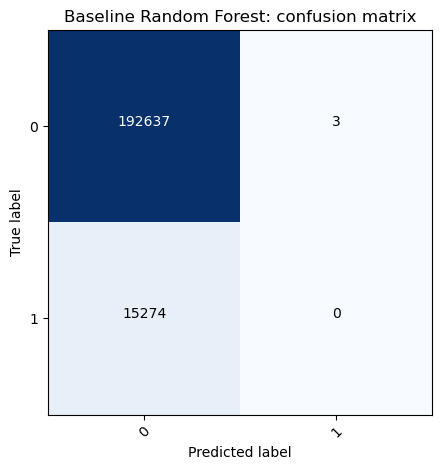

In [25]:
cm = confusion_matrix(y_test, rf_y_preds >= thresholds[ix])
plot_confusion_matrix(cm, classes=['0', '1'], model_name='Baseline Random Forest')

In [26]:
print(classification_report(y_test, rf_y_preds >= thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192640
         1.0       0.00      0.00      0.00     15274

    accuracy                           0.93    207914
   macro avg       0.46      0.50      0.48    207914
weighted avg       0.86      0.93      0.89    207914



Due to the strong imbalance of the values of the target variable, our model ignores class 1 in about half of the cases.

### Model selection

The goal is to maximize the f1 score result of class 1.

In [28]:
def ppln_preds(ppln, X_train, y_train, X_test, y_test):
    ppln.fit(X_train, y_train)
    preds = ppln.predict(X_test)
    steps = '\n'.join(["    " + str(el[1]) for el in ppln.steps])
    print(f"Steps:\n{steps}\n")
    print(classification_report(y_test, preds))
#     return ppln, preds

#### LogisticRegression

In [58]:
log_reg_ppln = Pipeline([('logistic_regression', LogisticRegression(random_state=42))])

ppln_preds(log_reg_ppln, X_train, y_train, X_test, y_test)

Steps:
    LogisticRegression(random_state=42)

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192640
         1.0       0.00      0.00      0.00     15274

    accuracy                           0.93    207914
   macro avg       0.46      0.50      0.48    207914
weighted avg       0.86      0.93      0.89    207914



In [59]:
ppln_preds(
    Pipeline([("std_scaler", StandardScaler()), 
              ('logistic_regression', LogisticRegression(random_state=42))]), 
    X_train, y_train, X_test, y_test)

Steps:
    StandardScaler()
    LogisticRegression(random_state=42)

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192640
         1.0       0.29      0.01      0.01     15274

    accuracy                           0.93    207914
   macro avg       0.61      0.50      0.49    207914
weighted avg       0.88      0.93      0.89    207914



In [60]:
ppln_preds(
    Pipeline([('pca', PCA()),
              ("std_scaler", StandardScaler()), 
              ('logistic_regression', LogisticRegression(random_state=42))]), 
    X_train, y_train, X_test, y_test)

Steps:
    PCA()
    StandardScaler()
    LogisticRegression(random_state=42)

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192640
         1.0       0.29      0.01      0.01     15274

    accuracy                           0.93    207914
   macro avg       0.61      0.50      0.49    207914
weighted avg       0.88      0.93      0.89    207914



#### RandomForestClassifier

In [61]:
ppln_preds(
    Pipeline([('rnd_forest', RandomForestClassifier(random_state=42))]), 
    X_train, y_train, X_test, y_test)

Steps:
    RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    192640
         1.0       0.56      0.08      0.14     15274

    accuracy                           0.93    207914
   macro avg       0.75      0.54      0.55    207914
weighted avg       0.90      0.93      0.90    207914



In [62]:
ppln_preds(
    Pipeline([("std_scaler", StandardScaler()), 
              ('rnd_forest', RandomForestClassifier(random_state=42))]), 
    X_train, y_train, X_test, y_test)

Steps:
    StandardScaler()
    RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    192640
         1.0       0.57      0.08      0.15     15274

    accuracy                           0.93    207914
   macro avg       0.75      0.54      0.55    207914
weighted avg       0.91      0.93      0.90    207914



#### KNeighborsClassifier

In [63]:
ppln_preds(
    Pipeline([('knn', KNeighborsClassifier())]), 
    X_train, y_train, X_test, y_test)

Steps:
    KNeighborsClassifier()

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96    192640
         1.0       0.57      0.17      0.26     15274

    accuracy                           0.93    207914
   macro avg       0.75      0.58      0.61    207914
weighted avg       0.91      0.93      0.91    207914



The best f1-score in class 1 was shown by the KNeighborsClassifier model

### Tuning hyperparameters.

In [29]:
params={"n_neighbors":[1, 3, 5, 7], "metric":['minkowski','euclidean']}

In [30]:
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), 
             param_grid=params, 
             scoring="f1")

In [ ]:
grid_search.fit(X_train, y_train);

In [115]:
grid_search.best_params_

{'metric': 'minkowski', 'n_neighbors': 7}

In [33]:
ppln_preds(
    Pipeline([('knn', KNeighborsClassifier(n_neighbors=7, metric="minkowski"))]), 
    X_train, y_train, X_test, y_test)

Steps:
    KNeighborsClassifier(n_neighbors=7)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96    192640
         1.0       0.62      0.17      0.27     15274

    accuracy                           0.93    207914
   macro avg       0.78      0.58      0.62    207914
weighted avg       0.91      0.93      0.91    207914



In [36]:
best_model = Pipeline([('knn', KNeighborsClassifier(n_neighbors=7, metric="minkowski"))])

In [37]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=7))])

#### Saving model

In [40]:
with open("best_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

#### Making pipeline

In [55]:
ppln_final = Pipeline([('data_prepare', DataPreparation(data_test, data_features)),
                       ('column_select', ColumnSelector(X_train.columns)),
                        ('model', best_model)
])

In [56]:
test_preds = ppln_final.predict_proba(data_test)

In [60]:
answers = data_test.join(pd.DataFrame(test_preds)[1])
answers.rename(columns={1: 'target'}, inplace=True)

In [63]:
with open('./pipeline.pkl', 'wb') as f:
    pickle.dump(ppln_final, f)

In [64]:
with open("./answers.csv", 'wb') as f:
    answers.to_csv(f, encoding='utf-8', index=False)